In the [previous post](https://yigitasik.github.io/posts/Model%20Fitting%20with%20Likelihood/), the model was fit using a grid approximation for likelihood calculation under each hypothesis (i.e., for each pair of parameters). Now, let's take a step further and calculate *posterior distribution* and take the *marginal distribution* for each parameter (i.e, the intercept and the slope). If things seem complicated, I advice you to take a look at the [previous post](https://yigitasik.github.io/posts/Model%20Fitting%20with%20Likelihood/).

Although I posted about Bayesian approach [before](https://yigitasik.github.io/#category=Bayesian), it might be nice to summarize it a bit:

In my opinion, best summation of Bayesian way of thinking is made in a single sentence by John Kruschke in his book *Doing Bayesian Data Analysis*: 

    "Bayesian inference is reallocation of credibility across possibilities."

The word "reallocation" implies <ins>prior allocation</ins> of credibility across possibilities. Let me exemplify the whole thing:

I work in a hybrid office where we’re required to be present three days a week. We get to choose which days, but most of the team tends to come in on Wednesdays.

Last Wednesday, I headed to the office assuming that my team leader, Isil, would be there as well. At first, my belief strongly leaned toward her showing up due to my prior knowledge. When I arrived on our floor five minutes early and saw her laptop, my belief was strengthened.

However, as time passed and every other team member arrived—except Isil—my confidence started to fade. By 10 o’clock, I was almost certain she wasn’t coming in. Later, I found out she had to take the day off.

This is a nice real-life demonstration of Bayesian view: At the very start, I had a subjective degree of belief about Isil showing up. As I collected more data (e.g., spotting her laptop, others arriving etc.), I updated that belief and it gradually shifted towards the opposite direction.

On the example above, I had an *informative prior*: It wasn't 50-50 (equally likely) in terms of her showing up or not. On the other hand, [this example](https://yigitasik.github.io/posts/Bayes%20Theorem/) started with an *uninformative prior* where each hypothesis is equally likely.

Now, for this one, I'll do a very similar thing: I'll have a prior distribution for each parameter that represents my prior belief about its possible values (i.e., "possibilities above"). Then, I'll repeat the steps that I did in the [previous post](https://yigitasik.github.io/posts/Model%20Fitting%20with%20Likelihood/) and update my belief accordingly.

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels as sm
import empiricaldist as emd
import scipy.stats as st

import utils as ut

import warnings

warnings.filterwarnings('ignore')

In [2]:
possum = pd.read_csv('possum.csv', usecols=['pop', 'tail_l'])
df = possum.copy()

df.head(3)

,pop,tail_l
0,Vic,36.0
1,Vic,36.5
2,Vic,39.0


I have the same [data](https://www.openintro.org/data/index.php?data=possum) as before where each row corresponds to features of a possum from Australia and New Guinea. Same as before, let's attempt to predict which region a possum is from via its tail length.

In [3]:
qs_cept = np.linspace(-1.2, 0.8, 281) # possible values for intercept (beta_0)
qs_slope = np.linspace(-1.4, 0, 221) # possible values for slope (beta_1)

I'll create a uniform distribution for both set of possible values (i.e., *sample spaces*), where each value is equally likely.

In [4]:
uniform_cept = pd.Series(data=[1/len(qs_cept) for qs in qs_cept], index=qs_cept)
uniform_cept.head(3)

-1.200000    0.003559
-1.192857    0.003559
-1.185714    0.003559
dtype: float64

In [5]:
uniform_slope = pd.Series(data=[1/len(qs_slope) for qs in qs_slope], index=qs_slope)
uniform_slope.head(3)

-1.400000    0.004525
-1.393636    0.004525
-1.387273    0.004525
dtype: float64

Taking their outer product gives us the joint distribution. 

Heads up: If your priors are normalized (i.e., sum up to 1), so does your joint as well.

In [6]:
## Joint dist

A, B = np.meshgrid(uniform_slope, uniform_cept)

df_prior = pd.DataFrame(A*B, columns=uniform_slope.index, index=uniform_cept.index)
df_prior.iloc[:4, :4]

,-1.400000,-1.393636,-1.387273,-1.380909
-1.200000,0.000016,0.000016,0.000016,0.000016
-1.192857,0.000016,0.000016,0.000016,0.000016
-1.185714,0.000016,0.000016,0.000016,0.000016
-1.178571,0.000016,0.000016,0.000016,0.000016


In [7]:
df_prior = df_prior.stack()
df_prior.head(3)

-1.2  -1.400000    0.000016
      -1.393636    0.000016
      -1.387273    0.000016
dtype: float64

Now the dataframe for prior distribution is ready. Each row, column pair represents possible pair of values for both parameters.

Although it's not necessary, I'm going to create a different dataframe that represents likelihoods.

In [8]:
df_likeli = pd.DataFrame(index=qs_cept, columns=qs_slope)
df_likeli.fillna(1, inplace=True)
df_likeli = df_likeli.stack()

df_likeli.head(3)

-1.2  -1.400000    1
      -1.393636    1
      -1.387273    1
dtype: int64

Now, I ask this question: For each pair of intercept and slope, b0 and b1, how likely I am to see the observed data?

In [9]:
df['pop'] = df['pop'].apply(lambda x: 1 if x == 'Vic' else 0) # dummy coding

In [10]:
# Centering data

offset = df['tail_l'].mean().round()
df['x'] = df['tail_l'] - offset
df['y'] = df['pop']

# I refer our predictor as x from now on (for convenience), y becomes our target variable which takes 1 if possum is from Victoria region and 0 otherwise.

In [11]:
agg_data = df.groupby('x')['y'].agg(['sum', 'count'])
agg_data.head(10).T

x,-5.0,-3.5,-3.0,-2.5,-2.0,-1.5,-1.0,-0.5,0.0,0.5
sum,2,1,4,2,6,6,9,4,4,1
count,2,1,5,2,9,7,13,12,6,4


In [12]:
ns = agg_data['count'] # represents number of observation with corresponding x values
ks = agg_data['sum'] # represents successes, which means Victoria region

In [13]:
from scipy.special import expit # inverse of logit

x_values = agg_data.index # these are centered

for cept, slope in df_likeli.index:
    probs = expit(cept + slope * x_values) # transformation to probabilities
    likelis = st.binom.pmf(ks, ns, probs) # likelihood of each observation
    df_likeli[cept, slope] = likelis.prod() # likelihood of the whole data under the selected pair of parameter values

In [14]:
df_likeli.head(6)

-1.2  -1.400000    4.812632e-15
      -1.393636    5.218338e-15
      -1.387273    5.654017e-15
      -1.380909    6.121460e-15
      -1.374545    6.622520e-15
      -1.368182    7.159117e-15
dtype: float64

In [15]:
df_posterior = df_prior * df_likeli
df_posterior.head(6) # unnormalized

-1.2  -1.400000    7.749685e-20
      -1.393636    8.402985e-20
      -1.387273    9.104551e-20
      -1.380909    9.857265e-20
      -1.374545    1.066411e-19
      -1.368182    1.152818e-19
dtype: float64

In [16]:
df_posterior = df_posterior / df_posterior.sum()
df_posterior.head() # normalized

-1.2  -1.400000    8.913907e-09
      -1.393636    9.665351e-09
      -1.387273    1.047231e-08
      -1.380909    1.133810e-08
      -1.374545    1.226616e-08
dtype: float64

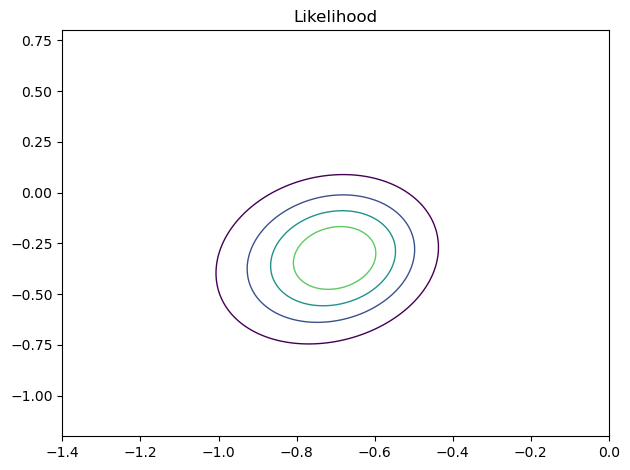

In [17]:
ut.plot_contour(df_likeli.unstack())
ut.decorate(title = 'Likelihood')

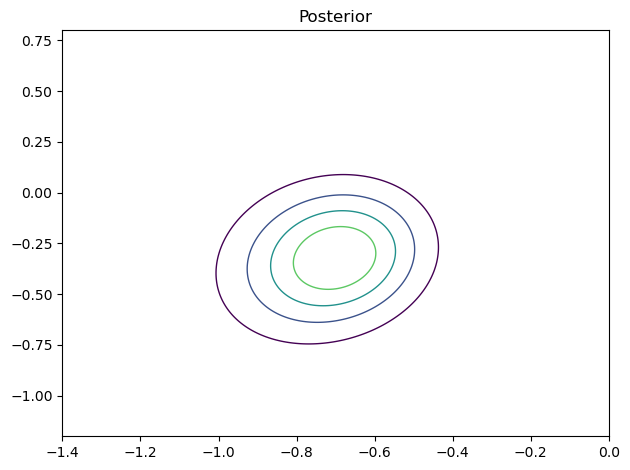

In [18]:
ut.plot_contour(df_posterior.unstack())
ut.decorate(title = 'Posterior')

In Bayesian framework, the posterior distribution is a negotiation between the prior distribution and the likelihood: If the prior does not have much leverage (i.e., if it's uninformative) then likelihood gets what it wants. In this case, since the prior was uniform, the likelihood dominated. Hence, both the likelihood and the posterior distribution are exactly the same.

### MARGINAL DISTRIBUTIONS

Now, I sum the values for slope to get the marginal distribution. For example, to get the probability of slope being -1.2, I need to fix the slope to -1.2 and let the intercept vary and calculate the probabilities for every pair, and sum them up to get the total probability. Well, we do have the probabilities so only thing left to do is to sum them up.

-0.706


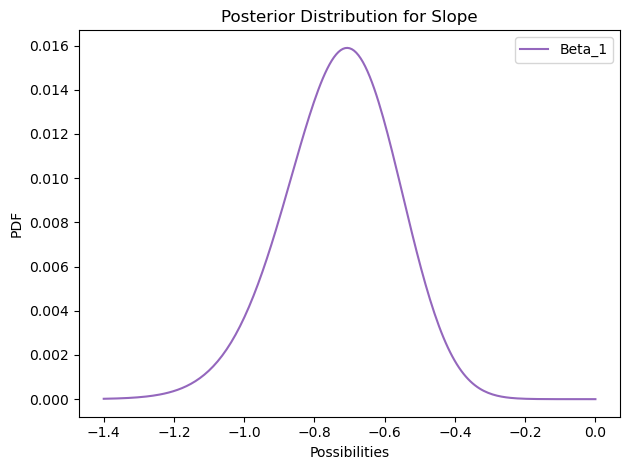

In [19]:
marginal_slope = df_posterior.unstack().sum(axis=0)
marginal_slope.plot(label='Beta_1', color='C4')

print(round(marginal_slope.idxmax(), 3))

ut.decorate(
    xlabel='Possibilities',
    ylabel='PDF',
    title = 'Posterior Distribution for Slope'
)

The mean of the distribution is around -0.7, which means that 1 unit increase in tail length decreases the log(odds) in favor of a possum being from Victorian, by 0.7.

-0.321


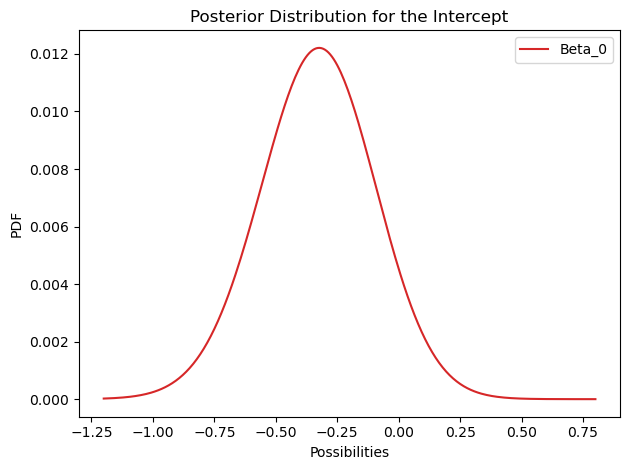

In [20]:
marginal_cept = df_posterior.unstack().sum(axis=1)
marginal_cept.plot(label='Beta_0', color='C3')

print(round(marginal_cept.idxmax(), 3))

ut.decorate(
    xlabel='Possibilities',
    ylabel='PDF',
    title = 'Posterior Distribution for the Intercept'
)

On the [previous post](https://yigitasik.github.io/posts/Model%20Fitting%20with%20Likelihood/), I had point estimates: Single pair of values for both parameters that maximizes the likelihood of the data. Now, instead of single pair, the result is distribution of possible values for each parameter.

One more trick before moving on: It is possible transform distributions to show probabilities. Let's do it for the intercept, $\beta_0$.

In [21]:
marginal_cept.index = np.exp(marginal_cept.index) # getting rid of the log
marginal_cept.index = marginal_cept.index / (marginal_cept.index + 1) # turning odds into probabilities

print(round(marginal_cept.idxmax(), 3))

0.42


So, the mean of the distribution is around 42%, standing for probability of Victorian possum when the tail length is 37 cm.

### PREDICTIONS

So, how to make predictions out of this?

First, let's put the posterior distribution to a pmf object.

In [22]:
posterior_pmf = emd.Pmf(df_posterior)
posterior_pmf.head()

-1.2  -1.400000    8.913907e-09
      -1.393636    9.665351e-09
      -1.387273    1.047231e-08
dtype: float64

Pmf object offers "choice" method that allows to sample from the distribution. I'll sample pairs from the joint distribution.

In [23]:
sample = posterior_pmf.choice(201)

In [24]:
min_tail_length = df['tail_l'].min() - 1
max_tail_length = df['tail_l'].max() + 1

Creating values to make predictions for.

In [25]:
xs = np.array([num-offset for num in np.arange(min_tail_length, max_tail_length, 0.5)])

In [26]:
pred = np.empty((len(sample), len(xs)))

for i, (cept, slope) in enumerate(sample):
    odds = np.exp(cept + slope * xs)
    pred[i] = odds / (odds + 1)

Okay, ended up with a list of predictions for each x under sampled model parameters. Let's put them into a graph to observe most likely values at different tail lengths.

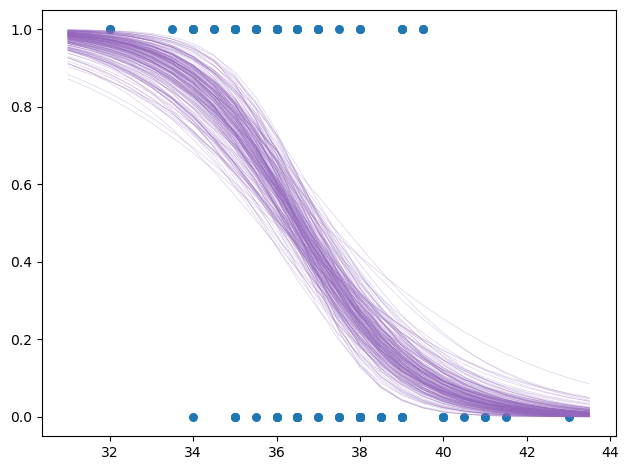

In [27]:
for ps in pred:
    plt.plot(xs+offset, ps, color='C4', lw=0.5, alpha=0.3)

plt.scatter(df['x']+offset, df['y'], s=30)
ut.decorate()

In [28]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)

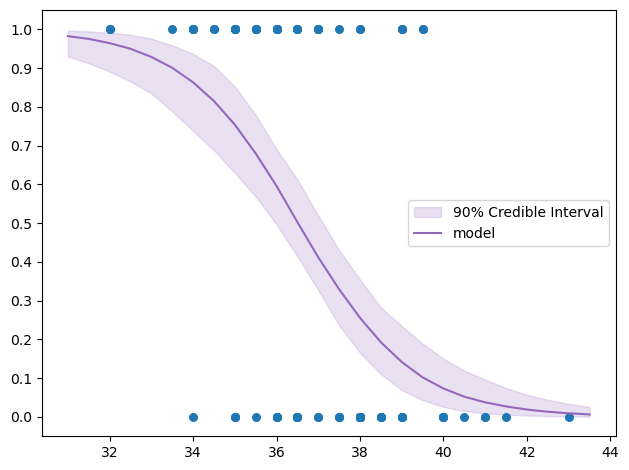

In [29]:
plt.fill_between(xs+offset, low, high, color='C4', alpha=0.2, label='90% Credible Interval')
plt.plot(xs+offset, median, color='C4', label='model')
plt.scatter(df['x']+offset, df['y'], s=30)

plt.yticks([val/10 for val in np.arange(0, 11)])

ut.decorate()

Don't worry about credible intervals / highest density intervals (HDIs), I think about talking about them in a different post.

Let's make a prediction: For example, what's the probability of Victorian if the tail length is 33 cm?

In [30]:
low = pd.Series(low, xs+offset)
median = pd.Series(median, xs+offset)
high = pd.Series(high, xs+offset)

In [31]:
tail_l = 33
print(
    round(median[tail_l], 3),
    (round(low[tail_l], 3), round(high[tail_l], 3))
)

0.929 (0.835, 0.976)


The probability of Victorian given the tail length of 33 cm is at least 83.5%.

That's pretty much it. I posted this blog as a follow-up to the [previous one](https://yigitasik.github.io/posts/Model%20Fitting%20with%20Likelihood/), hoping to make the relation between likelihood and posterior apparent. If you enjoyed it, you may consider subscribing to the email list.

Have a nice weekend!